# Obtaining the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
print(f"Shape of the training data: {X.shape}")

Shape of the training data: (70000, 784)


In [4]:
# Utility function to print an image from the dataset
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [5]:
random_digit_idx = 123
random_digit = X[random_digit_idx]
print(f"random_digit looks like this: {random_digit.shape}")
print("There is one row 784 values. Each value represents the intensity of a specific pixel.")

random_digit looks like this: (784,)
There is one row 784 values. Each value represents the intensity of a specific pixel.


The image looks like the below, and based on the label it is actually a 7


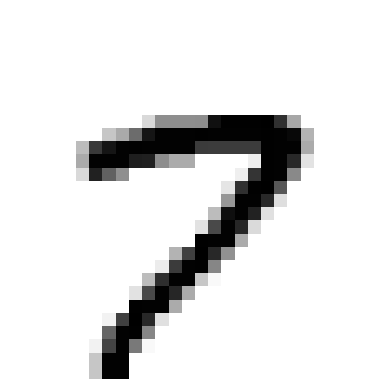

In [6]:
plot_digit(random_digit)
print(f"The image looks like the below, and based on the label it is actually a {y[123]}")

In [7]:
# Splitting into training and test set
# MNIST automatically handles the shuffling and any stratification by default
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier (7 or Not 7)

In [8]:
y_train_7 = (y_train == '7')
print(y_train_7.shape) # we see that it maintains the same shape, but just has false 
# for every instance that is not a 7

idx_7 = []
idx_not_7 = []
for i in range(len(y_train_7)):
    if y_train_7[i] == True:
        idx_7.append(i)
    else:
        idx_not_7.append(i)

print(f"Total number of 7s: {len(idx_7)}")
print(f"Total number of not 7s: {len(idx_not_7)}")

(60000,)
Total number of 7s: 6265
Total number of not 7s: 53735


### How a Stochastic Gradient (SGD) classifier works
- Computes a score based on a decision function.
- If that score is greater than some threshold, it assigns the instance to the positive class. 
- Otherwise, it assigns the negative class.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)
# 7 will be the positive class 

SGDClassifier(random_state=42)

In [10]:
# Testing if the model can correctly identify our random digit
print(f"The model identifies our random_digit as:\
 {'7' if sgd_clf.predict([random_digit]) == False else 'Not 7.'}")

print(f"The random digit is actually a {y_train[random_digit_idx]}")

The model identifies our random_digit as: Not 7.
The random digit is actually a 7


In [11]:
# Incorrect result for the random digit, so let us try a few more.
import numpy as np

rand_idxs = np.random.randint(1, 60000, size=20) #generate 20 random from the train set
for rand_idx in rand_idxs:
    if sgd_clf.predict([X_train[rand_idx]])[0] == False:
        print(f"Model prediction: Not a 7.")
    else:
        print(f"Model Prediction: 7")
    print(f"This instance is actually a: {y_train[rand_idx]}")
    print('*'*50)

Model prediction: Not a 7.
This instance is actually a: 9
**************************************************
Model Prediction: 7
This instance is actually a: 7
**************************************************
Model prediction: Not a 7.
This instance is actually a: 3
**************************************************
Model prediction: Not a 7.
This instance is actually a: 6
**************************************************
Model Prediction: 7
This instance is actually a: 7
**************************************************
Model prediction: Not a 7.
This instance is actually a: 7
**************************************************
Model prediction: Not a 7.
This instance is actually a: 0
**************************************************
Model prediction: Not a 7.
This instance is actually a: 6
**************************************************
Model prediction: Not a 7.
This instance is actually a: 8
**************************************************
Model prediction: Not a 7.
This i

# Measuring Accuracy Using Cross-Validation
- At a glance, the model does not seem to be doing too poorly. 
- But we can use cross validation to get a measure of the accuracy.

In [12]:
from sklearn.model_selection import cross_val_score

# Use 3 folds to 
accuracy_scores = cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring='accuracy')

In [13]:
print("SGD Classifier:")
for i in range(len(accuracy_scores)):
    print(f"- Fold {i+1} accuracy: {round(accuracy_scores[i]*100, 2)}%")

SGD Classifier:
- Fold 1 accuracy: 98.1%
- Fold 2 accuracy: 97.35%
- Fold 3 accuracy: 95.34%


## The Potential Problem with the Accuracy Metric
- >95% accuracy makes it seem like the model is performing really well.
- However, this just gives the percentage of classifications that are correct. 
- But, as shown below, the DummyClassifier ALWAYS predicts negative. Since only a small percentage of the 60,000 instances are 7s (10.44%), predicting False (value not a 7) will be correct the vast majority of the time.

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_7)
print(any(dummy_clf.predict(X_train))) # Check if any items in the list are true

# Evaluate the dummy classifier (which always predicts false) 's accuracy
dummy_accuracy_scores = cross_val_score(dummy_clf, X_train, y_train_7, cv=3, scoring='accuracy')


False


In [15]:
print("Dummy Classifier:")
for i in range(len(dummy_accuracy_scores)):
    print(f"- Fold {i+1} accuracy: {round(dummy_accuracy_scores[i]*100, 2)}%")

Dummy Classifier:
- Fold 1 accuracy: 89.56%
- Fold 2 accuracy: 89.56%
- Fold 3 accuracy: 89.56%


# Confusion Matrices
- In a binary classification context, a confusion matrix will show the number of:
    - True Positives (TP)
    - False Positives (FP)
    - True Negatives (TN)
    - False Negatives (FN)

In [16]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the PREDICTIONS made on each fold (instead of the score)
y_train_7_predictions = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

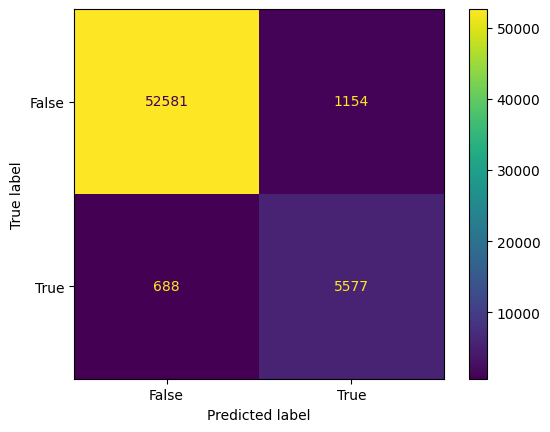

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train_7, y_train_7_predictions)
plt.show()

In the matrix above, we can see that the model identified:
- 52,581 digits that are not 7s as 7s
- 1154 digits that are actually not 7s as 7s
- 688 digits that are 7s as not 7s
- 5577 digits that are 7s as 7s

## Precision and Recall
- Because accuracy is not always the best measure, we use precision and recall.
- **Precision**:
    - *In English*: The accuracy of the positive predictions.
    - If the model predicts that the instance is positive, what is the likelihood that this prediction is correct.
    - Calculated by: $ \frac{TP}{TP + FP} $
- **Recall**:
    - *In English*: The ratio of actually positive instances that are identified as such.
    - If an item is of the positive class, how likely is it that the model detected it as such.
    - Calculated by: $ \frac{TP}{TP + FN} $

- The choice of whether to prefer a high **precision** or a high **recall** depends on the speicifc project. Examples:
    - Spam filter to detect spam emails:
        - It would be preferable to let a few spam messages end up in the inbox than to have a very important email misclassified as spam. Therefore, a high **precision** would be preferred. We need to make sure that we cna be really confident IF the classifier classes this as spam, then it is actually spam.
    - Medical diagnostic tool to identify cases of a rare but serious disease:
        - It would be preferable to misdiagnose someone as *having* the disease, than to have someone who actually ahs the disease being diagnosed as not having it. Someone who is incorrectly classed as having the disease will likely catch this in subsequent tests. So a high **recall** is preferred.
    - A search engine which you only want to display results relevant to the user's query:
        - It is more important that if a result is returned, it is actually relevant to the user's query than it is to ensure we capture EVERY possible relevant result. High **precision** is preferred here. 
    

In [18]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision Score of `7 or not 7` model: \
{round(precision_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

print(f"Recall Score of `7 or not 7` model: \
{round(recall_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

Precision Score of `7 or not 7` model: 82.86%
Recall Score of `7 or not 7` model: 89.02%


To translate these results:
- When our classifier claims a digit is a 7%, we can be 82.86% sure it is correct.
- Our classifier correctly detects 89.02% of all 7s.

## $F_1$ Score
- This is the harmonic mean of the precision and recall. 
- Whereas the regular mean treats all values equally, the harmonix mean gives much more weight to low values.
- The classifier will only get a high $F_1$ score if both precision and recall are high. The challenge with this, though, is that increasing precision reduces recall and vice-versa. There is a tradeoff. 

In [19]:
from sklearn.metrics import f1_score

print(f"F1 score of `7 or not 7 model: \
{round(f1_score(y_train_7, y_train_7_predictions) * 100, 2)}%")

F1 score of `7 or not 7 model: 85.83%


## How the Stochastic Gradient Descent (SGD) classifier works
1. It computes a score based on a decision function.
2. If that score is greater than a threshold, it assigns the instance to the positive class.
3. Otherwise, it assigns the negative class.

In [20]:
random_digit_decision_score = sgd_clf.decision_function([random_digit])
print(f"The score for our random digit is: {random_digit_decision_score[0]}")

The score for our random digit is: 8840.523290066321


- This means that once our score is greater than the threshold of 8840, the digit will be classified as a 7. 
- We can see that increasing the threshold would increase **precision**. i.e. only numbers that the model is EXTREMELY certain is a 7, will get classified as a 7. 
- Conversely, this will decrease recall, as it is likely some of the less certain digits will be classified as not a 7. 

In [21]:
threshold = 8000
# True if the score for the random digit is greater than the threshold
random_digit_prediction = (random_digit_decision_score > threshold)
print(random_digit_prediction)


[ True]


In [23]:
# Using cross validation to return the decision scores of the sgd classifier
y_decision_scores = cross_val_predict(sgd_clf, X_train, y_train_7, 
    cv=3, method='decision_function')

# y_decision_scores contains the decision score for each instance in X_train
# Those instances with a decision score over the specified threshold will be
# classified as 7s.

print(y_decision_scores)

[-26444.17375986 -29232.36194438 -24011.8285088  ... -24767.21328011
 -18076.58386084 -12330.55080778]


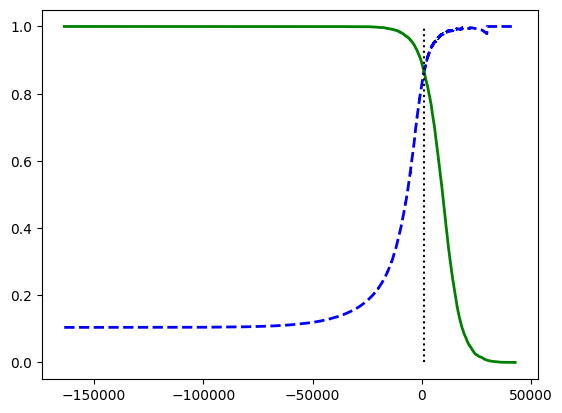

In [27]:
# We now want to plot a precision_recall_curve to plot the precision and 
# recall values for a number of different possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_7, 
    y_decision_scores)

threshold = 1000

# Defining the plot
# Precision line is blue dashed
# Recall line is green
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

Notes about the graph above:

- 

In [40]:
print(f"Total Precisions: {len(precisions)}")
print(f"Total Recalls: {len(recalls)}")
print(f"Total Thresholds: {len(thresholds)}")
print('*'*50)
for i in range(0, len(thresholds), 1000):
    print(f"Threshold: {thresholds[i]}")
    print(f"Precision: {precisions[i]}")
    print(f"Recall: {recalls[i]}")
    print('*'*20)

Total Precisions: 60001
Total Recalls: 60001
Total Thresholds: 60000
**************************************************
Threshold: -163657.52830886425
Precision: 0.10441666666666667
Recall: 1.0
********************
Threshold: -81015.96720255743
Precision: 0.1061864406779661
Recall: 1.0
********************
Threshold: -70793.14331035537
Precision: 0.10801724137931035
Recall: 1.0
********************
Threshold: -65066.19280015801
Precision: 0.10991228070175439
Recall: 1.0
********************
Threshold: -60566.56078959174
Precision: 0.111875
Recall: 1.0
********************
Threshold: -56938.20894717915
Precision: 0.11389090909090908
Recall: 0.9998403830806065
********************
Threshold: -54038.64683866636
Precision: 0.116
Recall: 0.9998403830806065
********************
Threshold: -51329.59332322259
Precision: 0.11818867924528302
Recall: 0.9998403830806065
********************
Threshold: -49022.94080152818
Precision: 0.12046153846153847
Recall: 0.9998403830806065
********************

-162768.14838551375